<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

# Embarrassingly parallel Workloads

This notebook shows how to use Dask to parallelize embarrassingly parallel workloads where you want to apply one function to many pieces of data independently.  It will show three different ways of doing this with Dask:

1. [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) 
2. [concurrent.Futures](https://dask.pydata.org/en/latest/futures.html) 
3. [dask.bag](https://dask.pydata.org/en/latest/bag.html)

This example focuses on using Dask for building large embarrassingly parallel computation as often seen in scientific communities and on High Performance Computing facilities, for example with Monte Carlo methods. This kind of simulation assume the following:

 - We have a function that runs a heavy computation given some parameters.
 - We need to compute this function on many different input parameters, each function call being independent.
 - We want to gather all the results in one place for further analysis.

## Start Dask Client for Dashboard

Starting the Dask Client will provide a dashboard which 
is useful to gain insight on the computation.  We will also need it for the
Futures API part of this example. Moreover, as this kind of computation
is often launched on super computer or in the Cloud, you will probably end
up having to start a cluster and connect a client to scale.  See 
[dask-jobqueue](https://github.com/dask/dask-jobqueue),
[dask-kubernetes](https://github.com/dask/dask-kubernetes) or 
[dask-yarn](https://github.com/dask/dask-yarn) for easy ways to achieve this
on respectively an HPC, Cloud or Big Data infrastructure.

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same time is very useful when learning.

In [1]:
from dask.distributed import Client, progress

In [9]:
client = Client(threads_per_worker=4, n_workers=1)
client

/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34273 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:34185' processes=1 threads=4, memory=540.15 GB>

In [16]:
client = Client( n_workers=1)
client

/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40881 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43233' processes=1 threads=64, memory=540.15 GB>

In [5]:
client = Client( n_workers=2)
client

/opt/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33795 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:46691' processes=2 threads=64, memory=540.15 GB>

In [9]:
client.cluster.scale(4)

In [10]:
client

<Client: 'tcp://127.0.0.1:33207' processes=4 threads=256, memory=2.16 TB>

## Define your computation calling function

This function does a simple operation: add all numbers of a list/array together, but it also sleeps for a random amount of time to simulate real work. In real use cases, this could call another python module, or even run an executable using subprocess module.

In [12]:
import time
import random

def costly_simulation(list_param):
    time.sleep(0.1)
    return sum(list_param)

We try it locally below

In [39]:
%time costly_simulation([1, 2, 3, 4])

CPU times: user 44.7 ms, sys: 7.65 ms, total: 52.3 ms
Wall time: 100 ms


10

## Define the set of input parameters to call the function

We will generate a set of inputs on which we want to run our simulation function. Here we use Pandas dataframe, but we could also use a simple list. Lets say that our simulation is run with four parameters called param_[a-d].

In [13]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

param_a   param_b   param_c   param_d
0  0.200487  0.470575  0.758324  0.937432
1  0.234845  0.342338  0.395061  0.040046
2  0.548420  0.930099  0.612068  0.606178
3  0.929931  0.517603  0.848173  0.457232
4  0.242126  0.710237  0.452512  0.829549

Without using Dask, we could call our simulation on all of these parameters using normal Python for loops.

Let's only do this on a sample of our parameters as it would be quite long otherwise.

In [41]:
results = []

In [42]:
%%time
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

CPU times: user 432 ms, sys: 15.6 ms, total: 448 ms
Wall time: 1 s


In [43]:
results

[1.9450264330228837,
 2.4352529226429933,
 2.7058481608014358,
 2.2971631054921264,
 1.1706217529562415,
 0.9580702928838651,
 2.4568668991363976,
 1.8779072590513866,
 2.1831296922434866,
 1.4121774090963184]

In [45]:
client

<Client: 'tcp://127.0.0.1:37889' processes=1 threads=4, memory=540.15 GB>

Note that this is not very clever as we can easily parallelize code. 

There are many ways to parallelize this function in Python with libraries like `multiprocessing`, `concurrent.futures`, `joblib` or others.  These are good first steps.  Dask is a good second step, especially when you want to scale across many machines.


## Use [Dask Delayed](http://dask.pydata.org/en/latest/delayed.html) to make our function lazy

We can call `dask.delayed` on our funtion to make it lazy.  Rather than compute its result immediately, it records what we want to compute as a task into a graph that we'll run later on parallel hardware. Using `dask.delayed` is a relatively straightforward way to parallelize an existing code base, even if the computation isn't embarrassingly parallel like this one. 

Calling these lazy functions is now almost free.  In the cell below we only construct a simple graph.

In [65]:
client.cluster.scale(3)

In [70]:
client

<Client: 'tcp://127.0.0.1:37889' processes=3 threads=12, memory=1.62 TB>

In [67]:
import dask
lazy_results = []

In [68]:
%%time

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 6.6 ms, sys: 0 ns, total: 6.6 ms
Wall time: 5.31 ms


In [69]:
%time dask.compute(*lazy_results)

CPU times: user 56.3 ms, sys: 1.89 ms, total: 58.2 ms
Wall time: 119 ms


(1.9450264330228837,
 2.4352529226429933,
 2.7058481608014358,
 2.2971631054921264,
 1.1706217529562415,
 0.9580702928838651,
 2.4568668991363976,
 1.8779072590513866,
 2.1831296922434866,
 1.4121774090963184)

Notice that this was faster than running these same computations sequentially with a for loop.  

We can now run this on all of our input parameters:

In [76]:
client.cluster.scale(3)  # ask for ten 4-thread workers
client

<Client: 'tcp://127.0.0.1:37889' processes=3 threads=12, memory=1.62 TB>

In [92]:
%%time
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)
    
futures = dask.persist(*lazy_results)  # trigger computation in the background

CPU times: user 237 ms, sys: 34.3 ms, total: 272 ms
Wall time: 241 ms


In [93]:
%%time
results = dask.compute(*futures)
# results = dask.compute(*lazy_results)
results[:5]

CPU times: user 156 ms, sys: 16.7 ms, total: 172 ms
Wall time: 163 ms


(1.9450264330228837,
 2.4352529226429933,
 2.7058481608014358,
 2.2971631054921264,
 1.1706217529562415)

In [17]:
%%time
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)
    
# futures = dask.persist(*lazy_results)  # trigger computation in the background

CPU times: user 342 ms, sys: 40.9 ms, total: 383 ms
Wall time: 346 ms


In [18]:
%%time
# results = dask.compute(*futures)
results = dask.compute(*lazy_results)
results[:5]

CPU times: user 386 ms, sys: 57.1 ms, total: 443 ms
Wall time: 1.06 s


(2.366818238530359,
 1.0122905556173705,
 2.6967653513111234,
 2.7529388008011906,
 2.2344248586750615)

In [80]:
dask-worker --nprocs 8 --nthreads 1


Delayed('costly_simulation-b2b79d29-4a67-4794-9db3-a0e719c20c6a')

In [94]:
dask-worker

NameError: name 'worker' is not defined

## Using the [Futures API](http://dask.pydata.org/en/latest/futures.html)

The same example can be implemented using Dask's Futures API by using the `client` object itself.  For our use case of applying a function across many inputs both Dask delayed and Dask Futures are equally useful.  The Futures API is a little bit different because it starts work immediately rather than being completely lazy.

For example, notice that work starts immediately in the cell below as we submit work to the cluster:

In [15]:
futures = []
for parameters in input_params.values:
    future = client.submit(costly_simulation, parameters)
    futures.append(future)

We can explicitly wait until this work is done and gather the results to our local process by calling `client.gather`:

In [16]:
results = client.gather(futures)
results[:5]

[0.5374585663321187,
 1.5631291073804745,
 2.561244430051625,
 1.4275782430967583,
 2.501960586670158]

But the code above can be run in fewer lines with `client.map()` function, allowing to call a given function on a list of parameters.

As for delayed, we can only start the computation and not wait for results by not calling `client.gather()` right now.

It shall be noted that as Dask cluster has already performed tasks launching `costly_simulation` with Futures API on the given input parameters, the call to `client.map()` won't actually trigger any computation, and just retrieve already computed results.

In [17]:
futures = client.map(costly_simulation, input_params.values)

Then just get the results later:

In [18]:
results = client.gather(futures)
len(results)

500

In [19]:
print(results[0])

0.5374585663321187


We encourage you to watch the [dashboard's status page](../proxy/8787/status) to watch on going computation.

## Doing some analysis on the results

One of the interests of Dask here, outside from API simplicity, is that you are able to gather the result for all your simulations in one call.  There is no need to implement a complex mechanism or to write individual results in a shared file system or object store.

Just get your result, and do some computation.

Here, we will just get the results and expand our initial dataframe to have a nice view of parameters vs results for our computation

In [20]:
output = input_params.copy()
output['result'] = pd.Series(results, index=output.index)
output.sample(5)

param_a   param_b   param_c   param_d    result
488  0.839218  0.539117  0.757886  0.579746  2.715967
330  0.242440  0.450380  0.557021  0.495924  1.745764
228  0.500576  0.479788  0.010624  0.508862  1.499849
313  0.906131  0.304856  0.219171  0.492022  1.922180
428  0.615756  0.433848  0.327770  0.229043  1.606417

Then we can do some nice statistical plots or save result locally with pandas interface here

<AxesSubplot:>

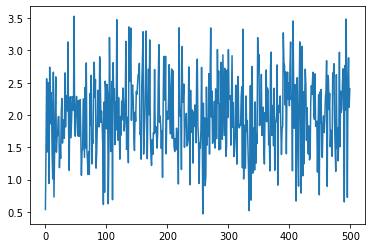

In [21]:
%matplotlib inline
output['result'].plot()

In [22]:
output['result'].mean()

1.9944680307742346

In [23]:
filtered_output = output[output['result'] > 2]
print(len(filtered_output))
filtered_output.to_csv('/tmp/simulation_result.csv')

239


## Handling very large simulation with [Bags](http://dask.pydata.org/en/latest/bag.html)

The methods above work well for a size of input parameters up to about 100,000.  Above that, the Dask scheduler has trouble handling the amount of tasks to schedule to workers.  The solution to this problem is to bundle many parameters into a single task.
You could do this either by making a new function that operated on a batch of parameters and using the delayed or futures APIs on that function.  You could also use the Dask Bag API.  This is described more in the documentation about [avoiding too many tasks](http://dask.pydata.org/en/latest/delayed-best-practices.html#avoid-too-many-tasks).

Dask Bags hold onto large sequences in a few partitions.  We can convert our `input_params` sequence into a `dask.bag` collection, asking for fewer partitions (so at most 100,000, which is already huge), and apply our function on every item of the bag.

In [24]:
import dask.bag as db
b = db.from_sequence(list(input_params.values), npartitions=100)
b = b.map(costly_simulation)

In [25]:
%time results_bag = b.compute()

CPU times: user 1.08 s, sys: 86 ms, total: 1.17 s
Wall time: 10 s


Looking on Dashboard here, you should see only 100 tasks to run instead of 500, each taking 5x more time in average, because each one is actually calling our function 5 times.

In [26]:
np.all(results) == np.all(results_bag)

True